# Notebook for Testing code


In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn.grid_search import ParameterGrid
from sklearn import decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import datetime
import pickle
import os
import pprint
import numpy.polynomial.polynomial as P
from mpl_toolkits.mplot3d import Axes3D
from cycling_rnn import *

## Plot settings

In [3]:
#cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
#sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

## Load stuff

In [71]:
RUN = './saves/8-27c/'
param_grid = pickle.load(open(RUN+'npsaves/param_grid.pickle', 'rb'))

sim = 0
cur_params = ParameterGrid(param_grid)[sim]
pprint.pprint(cur_params)

# List directory
# Number of sims in RUN
total_sims = len(os.listdir(RUN+'tb'))

# load x and y data
x = np.load(RUN+'npsaves/'+str(sim)+'x.npy')
y = np.load(RUN+'npsaves/'+str(sim)+'y.npy')
#os.listdir(RUN+'npsaves')

cur_params = ParameterGrid(param_grid)[sim]

{'activation': 'tanh',
 'beta1': 0.0,
 'beta2': 0.0,
 'monkey': 'D',
 'num_neurons': 100,
 'stddev_out': 0.0,
 'stddev_state': 0.0}


In [72]:
if cur_params['monkey']=='D':
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/drakeFeb_processed.mat')
else:
    data = sio.loadmat('/Users/jeff/Documents/Python/_projects/cyclingRNN/cousFeb_processed.mat')
    
emg = data['EMG']
m1 = data['M1']

x = x[:emg.shape[0], :emg.shape[1], :]
y = y[:emg.shape[0], :emg.shape[1], :]

## Do stuff

### curvature: method 1

In [ ]:
### method 1 of getting curvature (naive)

In [4]:
## curvature...
n = 2
A = np.random.randn((n))
B = np.random.randn((n))
C = np.random.randn((n))

In [5]:
def cross_id1(a,b,c):
    return np.dot(a,c)*b - np.dot(a,b)*c

def cross_id2(a,b):
    return np.sqrt(np.linalg.norm(a)**2*np.linalg.norm(b)**2 - np.dot(a,b)**2)

In [6]:
a = A-C
b = B-C

In [7]:
r = np.linalg.norm(a)*np.linalg.norm(b)*np.linalg.norm(a-b)/(2*cross_id2(a,b))
p = cross_id1(np.linalg.norm(a)**2*b - np.linalg.norm(b)**2*a, a, b)/(2*cross_id2(a,b)**2) + C

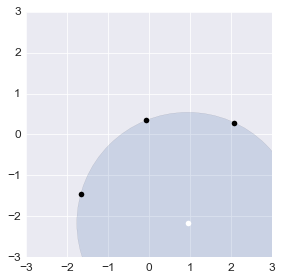

2.70868050382


In [8]:
plt.figure()
ax = plt.gca()
circle1 = plt.Circle((p[0], p[1]), r, alpha=0.2)
ax.add_artist(circle1)


plt.plot(A[0],A[1],'ko')
plt.plot(B[0],B[1],'ko')
plt.plot(C[0],C[1],'ko')
plt.plot(p[0],p[1],'wo')

plt.axis('square')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

plt.show()
print r

### curvature: method 2

In [ ]:
### method 2 of getting curvature (better)

In [225]:
def rand_signal(time_, cycle_, components_):
    """ 
    Create a size (T,) signal with lognormal distribution of component frequencies.
    """
    freq = 2*np.pi/cycle_*np.random.lognormal(mean=0, size=components_)
    phi = np.random.rand(components_)*cycle_
    z = np.sin(np.outer(time_, freq) + phi)
    z = z.sum(axis=1) # add up the sinusoids 
    z = (z - z.min()) / (z.max() - z.min()) # normalize
    z = 2*z - 1 # set range to [-1,1]
    return z

In [226]:
n = 2
t = 100
time = np.linspace(0., 1., t)

tmid = time[t/2]

points = np.zeros((t, n))
points_true = np.zeros((t, n))
for nn in range(n):
    points_true[:, nn] = 2*rand_signal(time, 1, 10)
points = points_true + 0.05*np.random.randn(t, n)

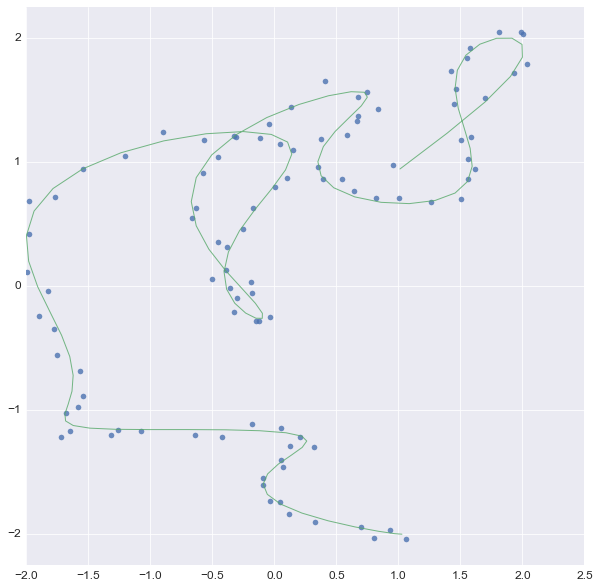

In [227]:
fig = plt.figure(figsize=(10,10))
if n>2:
    ax = fig.gca(projection='3d')
    plt.plot(points[:,0] ,points[:,1], points[:,2], 'o', linewidth=0.5, alpha=0.8)
    plt.plot(points_true[:,0] ,points_true[:,1], points_true[:,2], '-', linewidth=1.5, alpha=0.8)
else:
    plt.plot(points[:,0] ,points[:,1], 'o', linewidth=0.5, alpha=0.8)
    plt.plot(points_true[:,0] ,points_true[:,1], '-', linewidth=1, alpha=0.8)
plt.axis('equal')
plt.show()

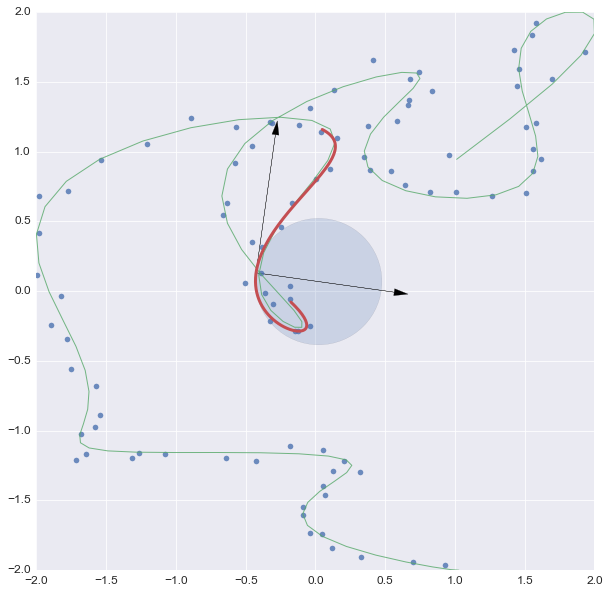

In [228]:
tref = 50

total_points = 15
deg = 4
k, e = get_generalized_curvature(points, total_points, deg)

total_curvatures = np.min((points.shape[1]-1, deg-1)) # have many curvatures to calculate

half = np.floor(total_points/2).astype(int)

times = np.arange(tref-half, tref+half+1)
times_local = times - tref # will always be -half:half
tmid = times_local[half] # tmid = 0
p = P.polyfit(times_local, points[times], deg)
pt = P.polyval(tmid, p)

times_plot = np.linspace(times_local[0], times_local[-1], 10*total_points)
p_plot = P.polyval(times_plot, p)

plt.figure(figsize=(10,10))
ax = plt.gca()

circle1 = plt.Circle(pt+1/k[tref,0]*e[tref][:,1], 1/k[tref,0], alpha=0.2)
ax.add_artist(circle1)

plt.plot(points[:,0], points[:,1],  'o', linewidth=1, alpha=0.8)
plt.plot(points_true[:,0], points_true[:,1],  '-', linewidth=1, alpha=0.8)
plt.plot(p_plot.T[:,0], p_plot.T[:,1], linewidth=3)

ax.arrow(pt[0], pt[1], e[tref][0,0], e[tref][1,0], head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.arrow(pt[0], pt[1], e[tref][0,1], e[tref][1,1], head_width=0.05, head_length=0.1, fc='k', ec='k')

plt.axis('equal')
plt.xlim([-2, 2])
plt.ylim([-2, 2])

plt.show()



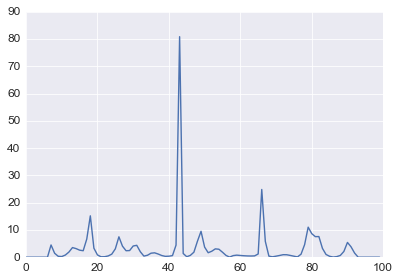

In [195]:
plt.plot(k)
plt.show()

In [44]:
p = P.polyfit(time, points, 4)
pp = [] # derivatives
pt = [] # evaluated at time tmid
for deriv in range(4):
    pp.append(P.polyder(p, deriv))
    pt.append(P.polyval(tmid, pp[-1]))

In [ ]:
p_plot = P.polyval(np.linspace(0, 0.5, 10*5), p)

In [ ]:
## Other method for calculating k
k = np.dot(pt[1], pt[1])*np.dot(pt[2], pt[2]) - np.dot(pt[1], pt[2])**2
k = k/np.dot(pt[1], pt[1])**3
k = np.sqrt(k)

In [ ]:
e1 = pt[1]/np.linalg.norm(pt[1])
e2_ = pt[2] - np.dot(pt[2], e1)*e1
e2 = e2_/np.linalg.norm(e2_)

In [ ]:
e1d = pt[2]/np.linalg.norm(pt[1])
kk = np.dot(e1d, e2)/np.linalg.norm(pt[1])

### curvature on data / rnn

In [205]:
tref = 100

total_points = 11
deg = 5

k_m1 = []
e_m1 = []

k_emg = []
e_emg = []

k_rnn = []
e_rnn = []

for c in range(4):
    k, e = get_generalized_curvature(m1[:,c,:], total_points, deg)
    k_m1.append(k)
    e_m1.append(e)
    
    k, e = get_generalized_curvature(emg[:,c,:], total_points, deg)
    k_emg.append(k)
    e_emg.append(e)

    k, e = get_generalized_curvature(x[:,c,:], total_points, deg)
    k_rnn.append(k)
    e_rnn.append(e)

    

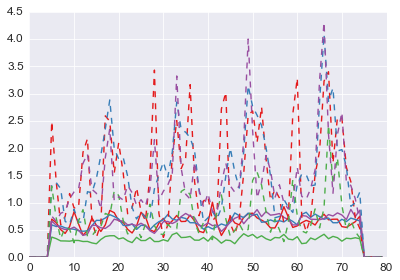

In [208]:
with sns.color_palette('Set1', 4):
    plt.figure()
    plt.plot(k_m1[3][:,:4],'-')
    plt.plot(k_emg[3][:,:4],'--')
    #plt.plot(k_rnn[0][:,:2],'-.')